<h2>Problem Statement </h2>

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ 

Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.


Objective: Identify the type of mutation given gene, variation and clinical literature.

Dataset:
https://www.kaggle.com/c/msk-redefining-cancer-treatment/data


In [1]:
# import statements

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
import nltk
from nltk.corpus import stopwords

# data split
from sklearn.model_selection import train_test_split

# vectorize
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

# models
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier


#perf eval
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


<h4>Load the dataset</h4>

In [2]:
df_1 = pd.read_csv("training/training_variants.csv")
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [3]:
df_1.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
df_2 = pd.read_csv("training/training_text", engine="python", sep="\|\|", names=["ID", "Text"], skiprows=1)
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   Text    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [5]:
df_2.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
# merge the datafames
df = pd.merge(df_1, df_2, on='ID', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
 4   Text       3316 non-null   object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [7]:
df.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [8]:
#df.sample(1)["Text"].values

<h2>1. Exploratory Data Analysis</h2>

<b>Utility function to visualize categorical features</b>

In [9]:
def visualize_categorical_variable(df, var, n_labels = None):
    
    if n_labels:
        df_show = df[var].value_counts()[:n_labels]
    else:
        df_show = df[var].value_counts()
    
    print(f"Variable name: {var}")
    print("Count distribution")
    print(df_show)
    print("\nNormalized distribution")
    if n_labels:
        print(df[var].value_counts(normalize=True)[:n_labels])
    else:
        print(df[var].value_counts(normalize=True))
    print("\nGraph")
    print(df_show.plot(kind='bar'))
    

In [10]:
#def 

<b>Class label Distribution</b>

Variable name: Class
Count distribution
7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

Normalized distribution
7    0.286962
4    0.206564
1    0.171033
2    0.136104
6    0.082806
5    0.072870
3    0.026799
9    0.011141
8    0.005721
Name: Class, dtype: float64

Graph
AxesSubplot(0.125,0.125;0.775x0.755)


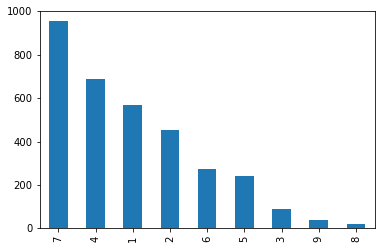

In [11]:
# variable: "Class"

visualize_categorical_variable(df, "Class")

Conclusion: There is imbalance in label distribution

<b>Feature: Gene </b>

In [12]:
df["Gene"].unique()

array(['FAM58A', 'CBL', 'SHOC2', 'TERT', 'DICER1', 'PTPRT', 'RHEB',
       'SHQ1', 'CCND2', 'RAD50', 'CCND3', 'RIT1', 'CCNE1', 'RYBP',
       'TGFBR1', 'TGFBR2', 'MSH6', 'KMT2D', 'LATS1', 'PBRM1', 'SF3B1',
       'LATS2', 'EGFR', 'NKX2-1', 'EIF1AX', 'ARID2', 'BRD4', 'HIST1H1C',
       'ERRFI1', 'CHEK2', 'PAK1', 'TMPRSS2', 'H3F3A', 'ELF3', 'ROS1',
       'ASXL2', 'CDH1', 'EPCAM', 'EP300', 'EPAS1', 'TP53', 'TP53BP1',
       'SMAD2', 'SMAD3', 'SMAD4', 'CDK4', 'AURKB', 'CDK6', 'FBXW7',
       'CDK8', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'ASXL1',
       'ERBB2', 'ERBB3', 'ERBB4', 'ERCC2', 'BRIP1', 'ERCC3', 'ERCC4',
       'ABL1', 'CEBPA', 'ERG', 'HLA-A', 'HLA-B', 'PDGFRA', 'PDGFRB',
       'RBM10', 'KDM5C', 'ESR1', 'ETV1', 'ETV6', 'TSC1', 'IKZF1', 'TSC2',
       'EWSR1', 'ACVR1', 'FOXA1', 'MDM2', 'ARID1A', 'EZH2', 'MDM4',
       'KLF4', 'RXRA', 'MAP3K1', 'AXIN1', 'BAP1', 'MEN1', 'FANCA',
       'FANCC', 'MET', 'U2AF1', 'KMT2C', 'FAT1', 'ARID1B', 'PIK3CA',
       'PIK3CB', 'PIM1

In [13]:
df["Gene"].nunique()

264

Variable name: Gene
Count distribution
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
PIK3CA     56
CDKN2A     52
FGFR2      50
FLT3       49
TSC2       47
MTOR       45
KRAS       44
MAP2K1     43
VHL        41
RET        40
Name: Gene, dtype: int64

Normalized distribution
BRCA1     0.079494
TP53      0.049082
EGFR      0.042457
PTEN      0.037940
BRCA2     0.037639
KIT       0.029810
BRAF      0.028004
ERBB2     0.020777
ALK       0.020777
PDGFRA    0.018067
PIK3CA    0.016862
CDKN2A    0.015658
FGFR2     0.015056
FLT3      0.014755
TSC2      0.014152
MTOR      0.013550
KRAS      0.013249
MAP2K1    0.012948
VHL       0.012346
RET       0.012045
Name: Gene, dtype: float64

Graph
AxesSubplot(0.125,0.125;0.775x0.755)


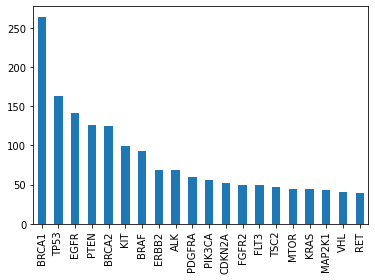

In [14]:
# visualize the top 20 Genes
visualize_categorical_variable(df, "Gene", n_labels = 20)

In [15]:
#list(df["Gene"].value_counts().index)
df["Gene"].value_counts().values

array([264, 163, 141, 126, 125,  99,  93,  69,  69,  60,  56,  52,  50,
        49,  47,  45,  44,  43,  41,  40,  39,  35,  33,  33,  33,  31,
        28,  26,  26,  26,  25,  25,  24,  24,  23,  23,  23,  22,  22,
        21,  21,  20,  20,  20,  20,  19,  19,  19,  18,  17,  16,  16,
        16,  16,  16,  16,  14,  14,  13,  13,  13,  13,  12,  12,  12,
        12,  11,  11,  11,  11,  11,  10,  10,  10,  10,   9,   9,   9,
         9,   9,   9,   9,   8,   8,   8,   8,   8,   8,   8,   8,   8,
         8,   7,   7,   7,   7,   7,   7,   7,   7,   7,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   5,   5,   5,   5,   5,   5,
         5,   5,   5,   5,   5,   5,   5,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   

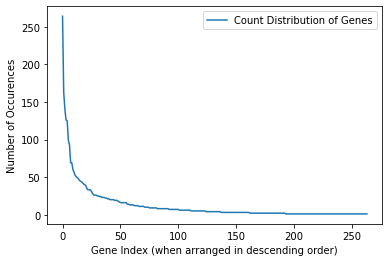

In [16]:
#plot to visualize the distribution of all Genes

y = df["Gene"].value_counts().values
plt.plot(y, label="Count Distribution of Genes")
plt.xlabel('Gene Index (when arranged in descending order)')
plt.ylabel('Number of Occurences')
plt.legend()

<b>Category: Variation</b>

In [17]:
df["Variation"].nunique()

2996

In [18]:
df.groupby(["Gene", "Variation"]).size()

Gene   Variation           
ABL1   BCR-ABL1 Fusion         1
       E255K                   1
       E255V                   1
       E279K                   1
       E281K                   1
                              ..
XRCC2  Truncating Mutations    1
YAP1   Amplification           1
       Fusions                 1
       YAP1-FAM118B Fusion     1
       YAP1-MAMLD1 Fusion      1
Length: 3321, dtype: int64

Variable name: Variation
Count distribution
Truncating Mutations         93
Deletion                     74
Amplification                71
Fusions                      34
Overexpression                6
G12V                          4
E17K                          3
Q61R                          3
T58I                          3
Q61H                          3
Q61L                          3
Promoter Hypermethylation     2
Y42C                          2
T73I                          2
Y64A                          2
F28L                          2
F384L                         2
R173C                         2
T167A                         2
S222D                         2
Name: Variation, dtype: int64

Normalized distribution
Truncating Mutations         0.028004
Deletion                     0.022282
Amplification                0.021379
Fusions                      0.010238
Overexpression               0.001807
G12V                         0.001204
E17K                         0.00

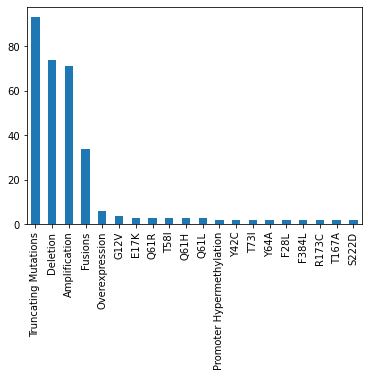

In [19]:
# visualize the top 20 Variations
visualize_categorical_variable(df, "Variation", n_labels = 20)

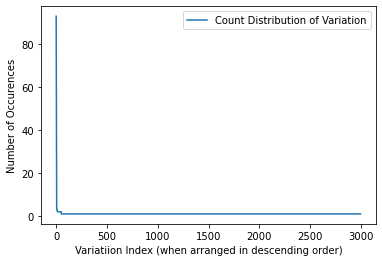

In [20]:
#plot to visualize the distribution of all Variations

y = df["Variation"].value_counts().values
plt.plot(y, label="Count Distribution of Variation")
plt.xlabel('Variatiion Index (when arranged in descending order)')
plt.ylabel('Number of Occurences')
plt.legend()

<b>Text field</b>

In [21]:
df["Text"].sample(1).values

array(['The tumor suppressor gene PTEN is frequently mutated in diverse human cancers and in autosomal dominant cancer predisposition disorders. Recent studies have shown that the lipid phosphatase activity of PTEN is critical for its tumor suppressor function and that PTEN negatively regulates the phosphatidylinositol 3*-kinase-protein kinase B pathway. Although more than half of PTEN mutations result in protein truncation, a significant fraction of PTEN mutations are missense mutations. To examine whether tumor-derived and germ-line-derived missense mutations inactivate PTEN lipid phosphatase function, we constructed 42 distinct types of PTEN missense mutations and expressed them in Escherichia coli. The purified (His)6-tagged PTEN proteins were tested for their ability to dephosphorylate inositol 1,3,4,5-tetrakisphosphate and phosphatidylinositol 3,4,5-triphosphate. In addition, we examined the effect of mutant PTENs on the ability of PTEN to bind to the phospholipid membrane. The r

In [22]:
# remove rows where Text is not present

In [23]:
df[df["Text"].isnull()]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [24]:
df = df[~df["Text"].isnull()]

In [25]:
#df[df['ID']==1109]["Text"].values

In [26]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
stop_words = set(stopwords.words('english'))


#         lemmatizer = spacy.load('en_core_web_md', disable = ['ner', 'tagger', 'parser', 'textcat'])
#         lemmatizer.max_length = 1500000 

In [27]:
# Text pre-processing

# remove special chars, whitespace, stopwords, convert text to lower

def preprocess_text(text):
    
    if type(text) is str:
    
        text = text.lower()
        # remove special chars
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        
        # remove extra whitespace
        text = re.sub('\s+',' ', text)
        
#         # tokenize
#         words = nltk.word_tokenize(text)
        
# #         # remove stopwords
# #         words = [w for w in words if not w in stop_words]
        
# # #         # spacy lemmatization
# # #         document = ' '.join(words)
# # #         doc_spacy = lemmatizer(document, disable=['tagger'])
# # #         lemmatized_text = [token.lemma_ for token in doc_spacy]

        words = [w for w in text.split() if not w in stop_words]

        return " ".join(words)
    else:
        return " "

In [28]:
df["Text"] = df["Text"].apply(preprocess_text)

In [29]:
df["Text"]

0       cyclin dependent kinases cdks regulate variety...
1       abstract background non small cell lung cancer...
2       abstract background non small cell lung cancer...
3       recent evidence demonstrated acquired uniparen...
4       oncogenic mutations monomeric casitas b lineag...
                              ...                        
3316    introduction myelodysplastic syndromes mds het...
3317    introduction myelodysplastic syndromes mds het...
3318    runt related transcription factor 1 gene runx1...
3319    runx1 aml1 gene frequent target chromosomal tr...
3320    frequent mutations associated leukemia recurre...
Name: Text, Length: 3316, dtype: object

In [30]:
#df["Text"].str.split().apply(len).value_counts()

<h2>2. Split the data into Train, CV and Test Set</h2>

Do a stratified split to maintain the distribution of samples across train, cv and test sets

In [31]:
type(df['Class'].values)

numpy.ndarray

In [32]:
print(len(df))

3316


In [33]:
# do a stratified split to maintain the distribution of samples across train, cv and test sets

y_true = df['Class'].values

# 64:20:16 (80% of 80 = 64)
X_train, test_df, y_train, y_test = train_test_split(df, y_true, 
                                                     stratify=y_true, 
                                                     test_size=0.2, 
                                                     random_state=7)

train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, 
                                                  stratify=y_train, 
                                                  test_size=0.2, 
                                                  random_state=7)

In [34]:
print(df.shape)
print(train_df.shape)
print(cv_df.shape)
print(test_df.shape)

(3316, 5)
(2121, 5)
(531, 5)
(664, 5)


In [35]:
#train_df.head()

<b>Sanity check : visualize the distribution of labels across train, cv and test set to ensure that the representativeness of labels is preserved</b>


Variable name: Class
Count distribution
7    609
4    439
1    362
2    289
6    174
5    155
3     57
9     24
8     12
Name: Class, dtype: int64

Normalized distribution
7    0.287129
4    0.206978
1    0.170674
2    0.136256
6    0.082037
5    0.073079
3    0.026874
9    0.011315
8    0.005658
Name: Class, dtype: float64

Graph
AxesSubplot(0.125,0.125;0.775x0.755)


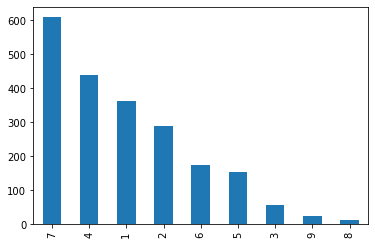

In [36]:
# train
visualize_categorical_variable(train_df, "Class")

Variable name: Class
Count distribution
7    152
4    110
1     91
2     72
6     44
5     39
3     14
9      6
8      3
Name: Class, dtype: int64

Normalized distribution
7    0.286252
4    0.207156
1    0.171375
2    0.135593
6    0.082863
5    0.073446
3    0.026365
9    0.011299
8    0.005650
Name: Class, dtype: float64

Graph
AxesSubplot(0.125,0.125;0.775x0.755)


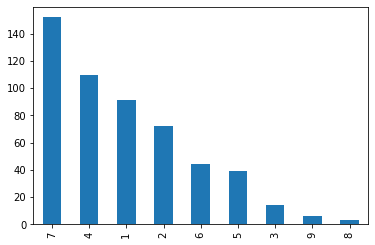

In [37]:
# cv
visualize_categorical_variable(cv_df, "Class")

Variable name: Class
Count distribution
7    191
4    137
1    113
2     91
6     55
5     48
3     18
9      7
8      4
Name: Class, dtype: int64

Normalized distribution
7    0.287651
4    0.206325
1    0.170181
2    0.137048
6    0.082831
5    0.072289
3    0.027108
9    0.010542
8    0.006024
Name: Class, dtype: float64

Graph
AxesSubplot(0.125,0.125;0.775x0.755)


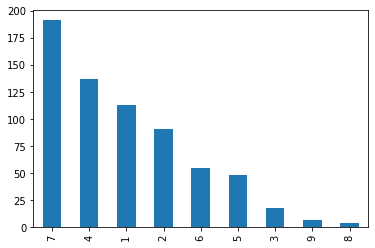

In [38]:
# test

visualize_categorical_variable(test_df, "Class")

<h2>Vectorize and prepare the input</h2>

In [39]:
# 1. Gene -> one-hot encoding

gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])


In [40]:
#type(train_gene_feature_onehotCoding)
train_gene_feature_onehotCoding

<2121x228 sparse matrix of type '<class 'numpy.int64'>'
	with 2121 stored elements in Compressed Sparse Row format>

In [41]:
gene_vectorizer.get_feature_names()[:7]

['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk']

In [42]:
## vectorize the cv and test input as well

test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

print(cv_gene_feature_onehotCoding.shape)
print(test_gene_feature_onehotCoding.shape)

(531, 228)
(664, 228)


In [43]:
# feature stability

In [44]:
# 2. Variation -> one-hot encoding

variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])


In [45]:
train_variation_feature_onehotCoding

<2121x1966 sparse matrix of type '<class 'numpy.int64'>'
	with 2411 stored elements in Compressed Sparse Row format>

In [46]:
variation_vectorizer.get_feature_names()[:7]

['11', '126', '13', '17', '19', '1_2009trunc', '20']

In [47]:
## vectorize the cv and test input as well

test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

print(cv_variation_feature_onehotCoding.shape)
print(test_variation_feature_onehotCoding.shape)

(531, 1966)
(664, 1966)


In [48]:
# feature stability

In [49]:
# Text -> BOW / TF-IDF / IDF / SIF 

text_vectorizer = CountVectorizer(min_df=3) 
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['Text'])

train_text_feature_onehotCoding

<2121x52844 sparse matrix of type '<class 'numpy.int64'>'
	with 3312842 stored elements in Compressed Sparse Row format>

In [50]:
text_vectorizer.get_feature_names()[12345:12350]

['chaperoning', 'chaperonins', 'chapman', 'chaps', 'chapter']

In [51]:
## vectorize the cv and test input as well

cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['Text'])
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['Text'])

print(cv_text_feature_onehotCoding.shape)
print(test_text_feature_onehotCoding.shape)

(531, 52844)
(664, 52844)


In [52]:
# feature stability

<b>Concatenate the three features</b>

In [53]:
# train data

#concatenate the features and convert it to Compressed Sparse Matrix Format (tocsr())
train_x_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(train_df["Class"])


In [54]:
print(f"Expected dimension of each vector = {train_gene_feature_onehotCoding.shape[1]+train_variation_feature_onehotCoding.shape[1]+train_text_feature_onehotCoding.shape[1]}")
print(train_x_onehotCoding.shape)
print(type(train_x_onehotCoding))

print(type(train_y))
print(train_y.shape)

Expected dimension of each vector = 55038
(2121, 55038)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>
(2121,)


In [55]:
# cv data

cv_x_onehotCoding = hstack((cv_gene_feature_onehotCoding, cv_variation_feature_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(cv_df["Class"])

cv_x_onehotCoding

<531x55038 sparse matrix of type '<class 'numpy.int64'>'
	with 807413 stored elements in Compressed Sparse Row format>

In [56]:
print(f"Expected dim of each vector = {cv_gene_feature_onehotCoding.shape[1]+cv_variation_feature_onehotCoding.shape[1]+cv_text_feature_onehotCoding.shape[1]}")
print(cv_x_onehotCoding.shape)

print(type(cv_y))
print(cv_y.shape)

Expected dim of each vector = 55038
(531, 55038)
<class 'numpy.ndarray'>
(531,)


In [57]:
# test data

test_x_onehotCoding = hstack((test_gene_feature_onehotCoding, test_variation_feature_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(test_df["Class"])


print(f"Expected dim of each vector = {test_gene_feature_onehotCoding.shape[1]+test_variation_feature_onehotCoding.shape[1]+test_text_feature_onehotCoding.shape[1]}")
print(test_x_onehotCoding.shape)

print(type(test_y))
print(test_y.shape)

Expected dim of each vector = 55038
(664, 55038)
<class 'numpy.ndarray'>
(664,)


<h2>4. Model Training and Hyperparameter Tuning </h2>

Get a baseline score

for alpha = 1e-05
Log Loss : 1.29771004893844
for alpha = 0.0001
Log Loss : 1.300491461369078
for alpha = 0.001
Log Loss : 1.3099252429772101
for alpha = 0.1
Log Loss : 1.304792281708445
for alpha = 1
Log Loss : 1.3207913175874633
for alpha = 10
Log Loss : 1.3717967091053072
for alpha = 100
Log Loss : 1.6761993175919525
for alpha = 1000
Log Loss : 1.793432287529573


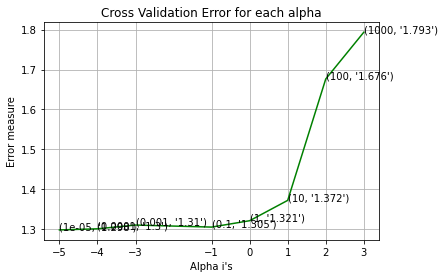

In [58]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    # use calibrated classifier to obtaiin actual probability values
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # log-probability -> to avoid rounding error while multiplying probabilites
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [60]:
# train the model on best value of 'alpha'
best_alpha = np.argmin(cv_log_error_array)

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Fraction of missclassified points :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])


Log Loss : 1.29771004893844
Fraction of missclassified points : 0.3935969868173258


<b> Utility function to plot confusion matrix </b>

In [68]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    #divide each element of the confusion matrix with the sum of elements in that column
    A =(((C.T)/(C.sum(axis=1))).T)
    
    #divid each element of the confusion matrix with the sum of elements in that row
    B =(C/C.sum(axis=0))
    

    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x) # o/p, o/p shape

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [67]:
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  10 The train log loss is: 0.8749867152368
For values of best alpha =  10 The cross validation log loss is: 1.2496823573691285
For values of best alpha =  10 The test log loss is: 1.1553616519249956


In [62]:
from sklearn.metrics import classification_report

#print(classification_report(y_true, y_pred, target_names=target_names))
#cv_y, sig_clf.predict(cv_x_onehotCoding.toarray())

print(classification_report(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray())))


              precision    recall  f1-score   support

           1       0.52      0.58      0.55        91
           2       0.49      0.47      0.48        72
           3       0.31      0.36      0.33        14
           4       0.68      0.57      0.62       110
           5       0.43      0.38      0.41        39
           6       0.83      0.45      0.59        44
           7       0.68      0.83      0.75       152
           8       0.00      0.00      0.00         3
           9       0.75      1.00      0.86         6

    accuracy                           0.61       531
   macro avg       0.52      0.52      0.51       531
weighted avg       0.61      0.61      0.60       531



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-61-ef2fee767f48>:8: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


-------------------- Confusion matrix --------------------


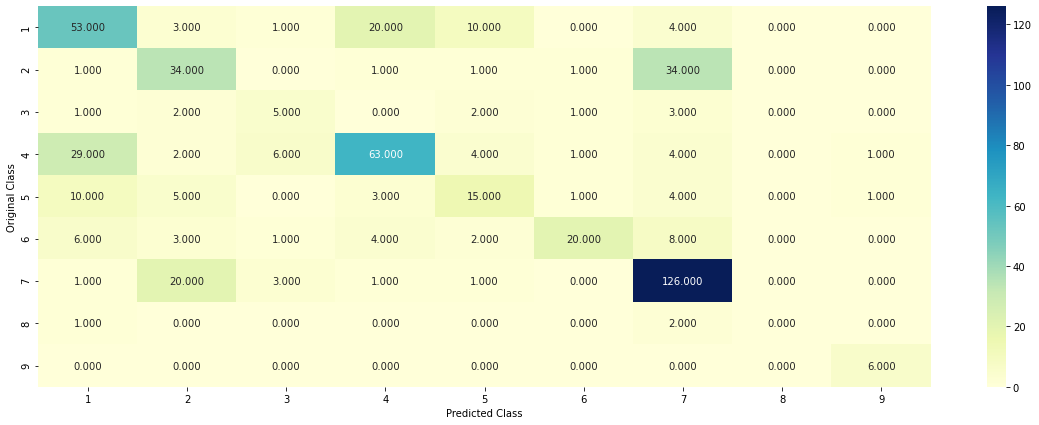

-------------------- Precision matrix (Columm Sum=1) --------------------


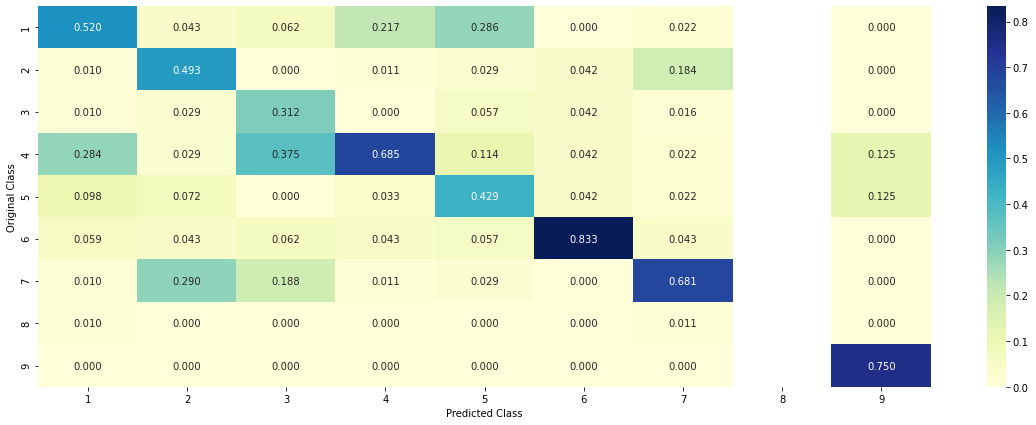

-------------------- Recall matrix (Row sum=1) --------------------


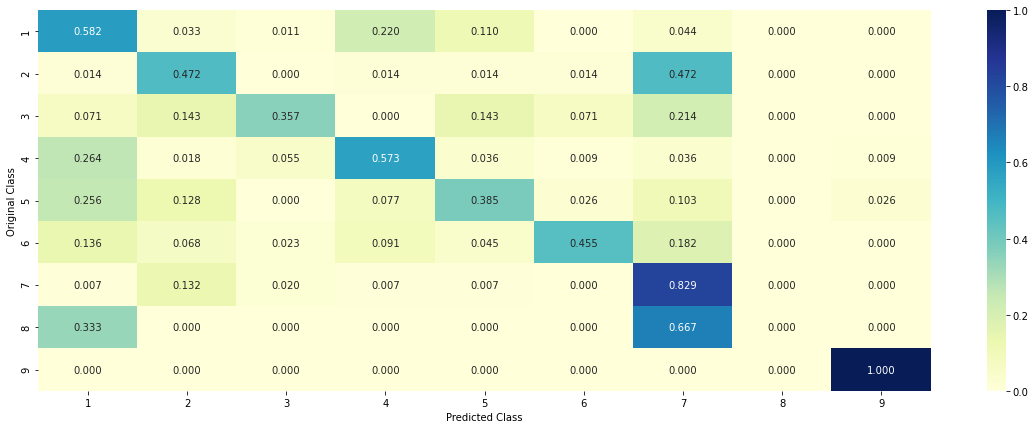

In [63]:
#plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

<b>Baseline model gives a log loss of 1.29</b>

In [ ]:
# TODO -> Model interpretability -> evaluate feature importance

<h4>Logistic Regression</h4>

for alpha = 1e-06
Log Loss : 1.831963784825079
for alpha = 1e-05
Log Loss : 1.831963784825079
for alpha = 0.0001
Log Loss : 1.8056815562301116
for alpha = 0.001
Log Loss : 1.3902720366153791
for alpha = 0.01
Log Loss : 1.332297015904423
for alpha = 0.1
Log Loss : 1.3338224122835467
for alpha = 1
Log Loss : 1.2532978784974076
for alpha = 10
Log Loss : 1.2496823573691285
for alpha = 100
Log Loss : 1.363560168132287


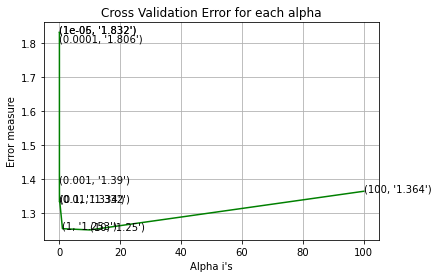

In [64]:

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [65]:
# train the model on best parameters

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=10,
                                                    class_weight='balanced',
                                                    loss='log',
                                                    random_state=42))

In [66]:
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  10 The train log loss is: 0.8749867152368
For values of best alpha =  10 The cross validation log loss is: 1.2496823573691285
For values of best alpha =  10 The test log loss is: 1.1553616519249956


Log loss : 1.2496823573691285
Number of mis-classified points : 0.4011299435028249
-------------------- Confusion matrix --------------------


<ipython-input-68-977ce0886276>:8: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


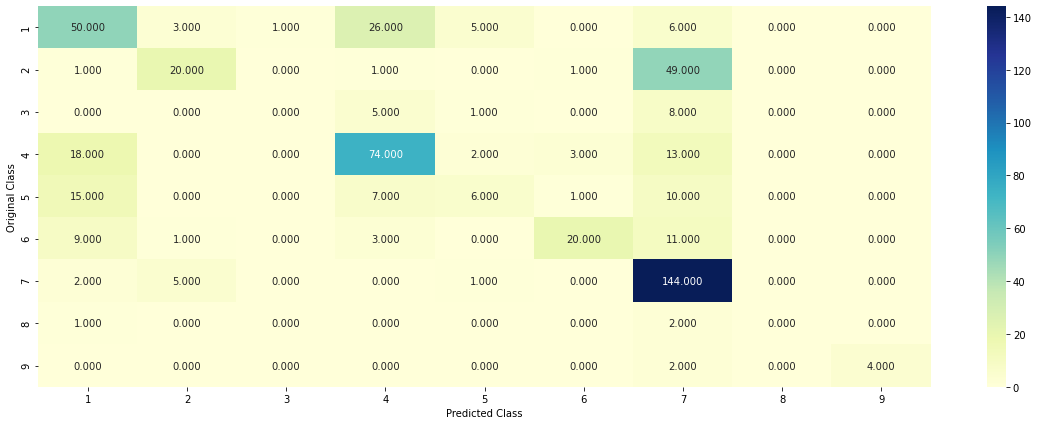

-------------------- Precision matrix (Columm Sum=1) --------------------


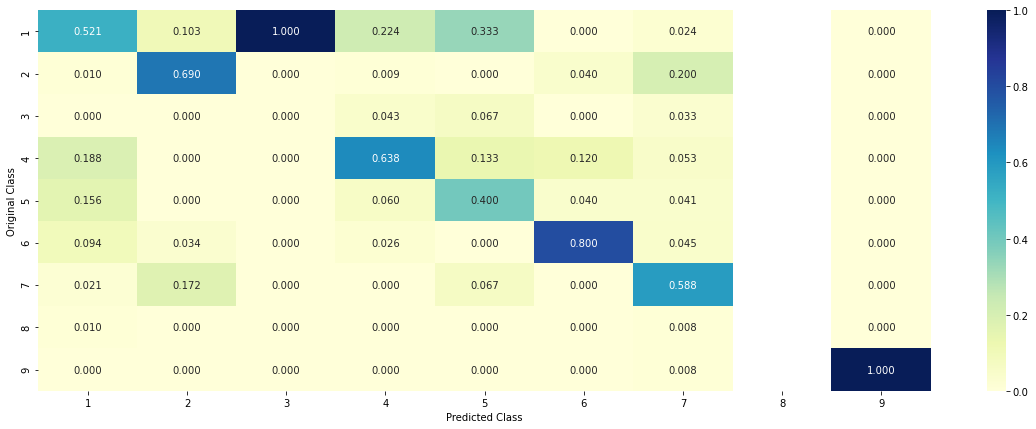

-------------------- Recall matrix (Row sum=1) --------------------


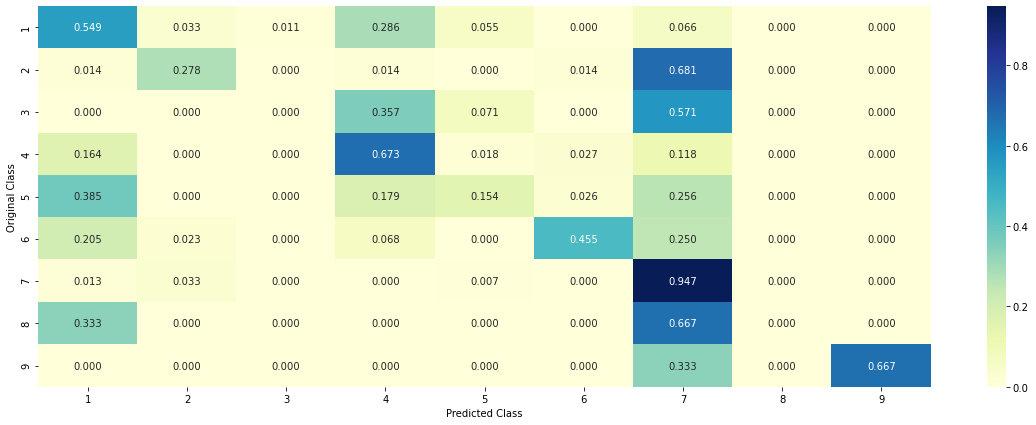

In [69]:
# plot confusion matrix

predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

Log loss improved to 1.25

<h4>Linear SVM </h4>

for C = 1e-05
Log Loss : 1.831963784825079
for C = 0.0001
Log Loss : 1.831963784825079
for C = 0.001
Log Loss : 1.3992834879895464
for C = 0.01
Log Loss : 1.3429053326537927
for C = 0.1
Log Loss : 1.3407798278529226
for C = 1
Log Loss : 1.3005918710965312
for C = 10
Log Loss : 1.2799160670956413
for C = 100
Log Loss : 1.3751386359964057


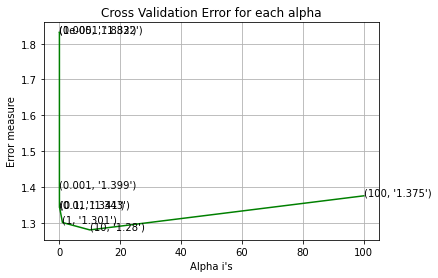

For values of best alpha =  10 The train log loss is: 0.8713968394408446
For values of best alpha =  10 The cross validation log loss is: 1.2799160670956413
For values of best alpha =  10 The test log loss is: 1.197086612446925


In [72]:

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.2799160670956413
Number of mis-classified points : 0.384180790960452
-------------------- Confusion matrix --------------------


<ipython-input-68-977ce0886276>:8: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


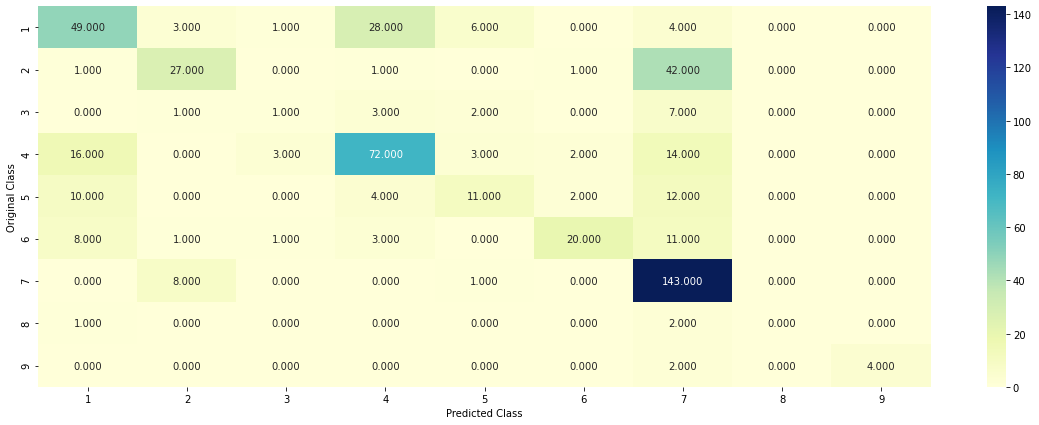

-------------------- Precision matrix (Columm Sum=1) --------------------


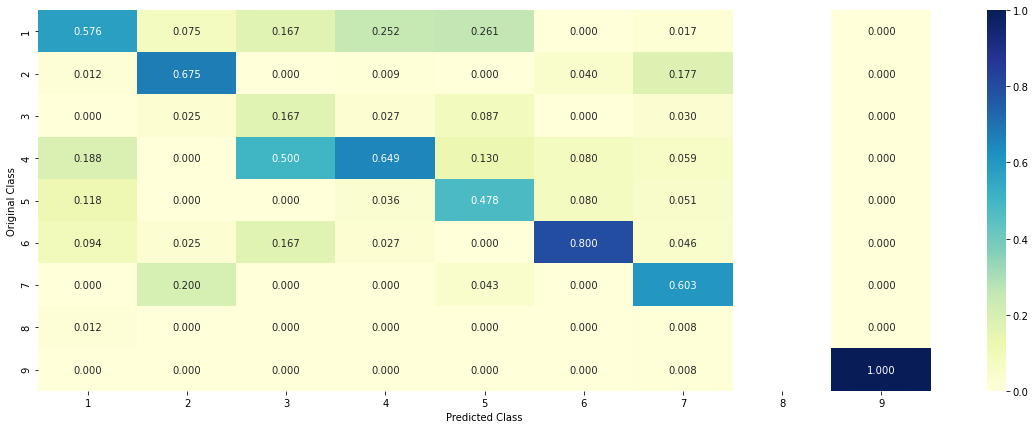

-------------------- Recall matrix (Row sum=1) --------------------


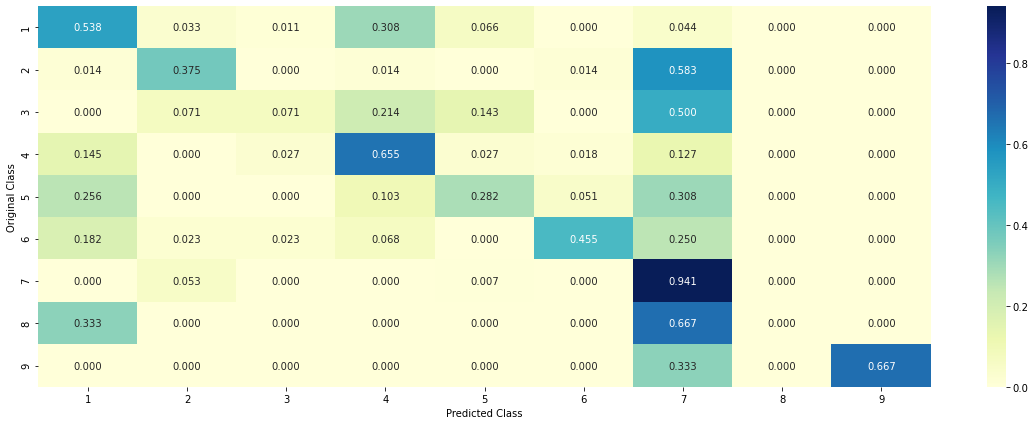

In [73]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)